In [ ]:
!pip install datasets
!pip install evaluate
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 16.3 MB/s eta 0:00:00
 

In [ ]:
from datasets import load_dataset
from transformers import get_scheduler, AdamW, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.auto import tqdm
import numpy as np
import evaluate
from evaluate import load as load_metric
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from datasets import concatenate_datasets, Dataset
from huggingface_hub import HfApi
from huggingface_hub import Repository
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from torch.nn import MSELoss
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.utils import resample
import itertools
import warnings

In [ ]:
bias_in_bios_dataset = load_dataset("LabHC/bias_in_bios")
bias_in_bios_dataset.shape

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.30k [00:00<?, ?B/s]

(…)-00000-of-00001-0ab65b32c47407e8.parquet:   0%|          | 0.00/64.9M [00:00<?, ?B/s]

(…)-00000-of-00001-5598c840ce8de1ee.parquet:   0%|          | 0.00/24.9M [00:00<?, ?B/s]

(…)-00000-of-00001-e6551072fff26949.parquet:   0%|          | 0.00/9.95M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/257478 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/99069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/39642 [00:00<?, ? examples/s]

{'train': (257478, 3), 'test': (99069, 3), 'dev': (39642, 3)}

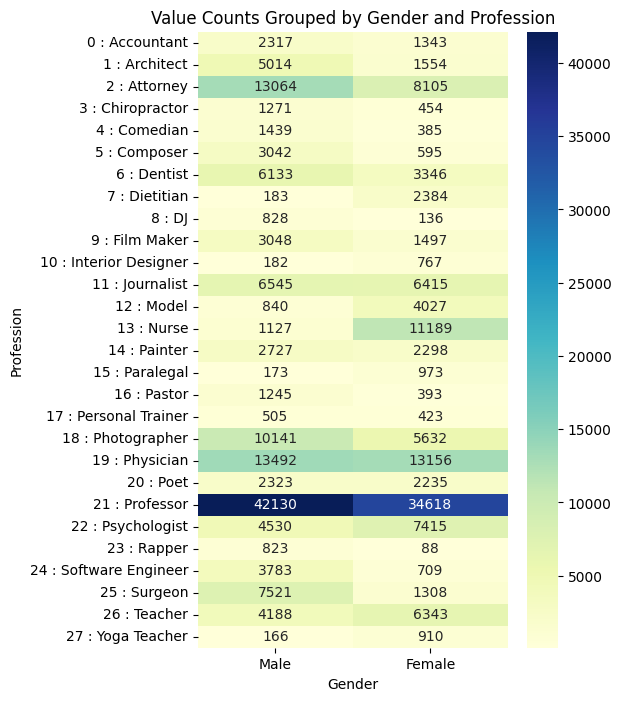

In [ ]:
df_pandas = pd.DataFrame(bias_in_bios_dataset['train'])
labels = ['0 : Accountant', '1 : Architect', '2 : Attorney', '3 : Chiropractor', '4 : Comedian', '5 : Composer',
          '6 : Dentist', '7 : Dietitian', '8 : DJ', '9 : Film Maker', '10 : Interior Designer', '11 : Journalist',
          '12 : Model', '13 : Nurse', '14 : Painter', '15 : Paralegal', '16 : Pastor', '17 : Personal Trainer',
          '18 : Photographer', '19 : Physician', '20 : Poet', '21 : Professor', '22 : Psychologist', '23 : Rapper',
          '24 : Software Engineer', '25 : Surgeon', '26 : Teacher', '27 : Yoga Teacher']
gen = ['Male', 'Female']
data = pd.crosstab(df_pandas['profession'], df_pandas['gender'])
plt.figure(figsize=(5,8))
sns.heatmap(data, annot=True, fmt = '.0f', cmap="YlGnBu" , yticklabels=labels, xticklabels=gen, annot_kws={"size":10})
plt.xlabel('Gender')
plt.ylabel('Profession')
plt.title('Value Counts Grouped by Gender and Profession')

plt.show()

In [ ]:
print(df_pandas['profession'].unique())

[21 13  2 11 20 25 26 22 19 16 14 18 24  5  6 27 17  7  0  9  1 12  3 23
  8  4 15 10]


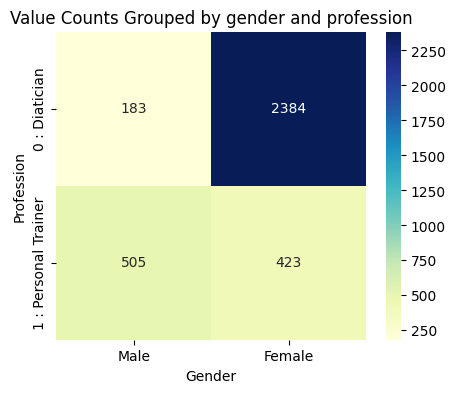

In [ ]:
df_pandas = df_pandas.loc[df_pandas['profession'].isin([7, 17])]
df_pandas
labels = ['0 : Diatician', '1 : Personal Trainer']
gen = ['Male', 'Female']
data = pd.crosstab(df_pandas['profession'], df_pandas['gender'])
plt.figure(figsize=(5,4))
sns.heatmap(data, annot=True, fmt = '.0f', cmap="YlGnBu" , yticklabels=labels, xticklabels=gen, annot_kws={"size":10})
plt.xlabel('Gender')
plt.ylabel('Profession')
plt.title('Value Counts Grouped by gender and profession')

plt.show()

In [ ]:
filtered_bias_in_bios = load_dataset("LabHC/bias_in_bios")

In [ ]:
# Diatician = 0   Personal Trainer = 1
def filter_and_change_values(example):
    if example['profession'] == 7:
        example['profession'] = 0
    elif example['profession'] == 17:
        example['profession'] = 1
    else:
        example['profession'] = None
    return example

# print(bias_in_bios_dataset['train'][:5])
print(filtered_bias_in_bios.shape)

for split in ['train', 'dev', 'test']:
    filtered_bias_in_bios[split] = filtered_bias_in_bios[split].map(filter_and_change_values)
    filtered_bias_in_bios[split] = filtered_bias_in_bios[split].filter(lambda x: x['profession'] in [0, 1])

print(filtered_bias_in_bios.shape)

data = pd.DataFrame(filtered_bias_in_bios['train'])

majority_class = data[data['profession'] == 0]
minority_class = data[data['profession'] == 1]

{'train': (257478, 3), 'test': (99069, 3), 'dev': (39642, 3)}


Map:   0%|          | 0/257478 [00:00<?, ? examples/s]

Filter:   0%|          | 0/257478 [00:00<?, ? examples/s]

Map:   0%|          | 0/39642 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39642 [00:00<?, ? examples/s]

Map:   0%|          | 0/99069 [00:00<?, ? examples/s]

Filter:   0%|          | 0/99069 [00:00<?, ? examples/s]

{'train': (3495, 3), 'test': (1347, 3), 'dev': (540, 3)}


profession
0             2567
1             2567
Name: count, dtype: int64


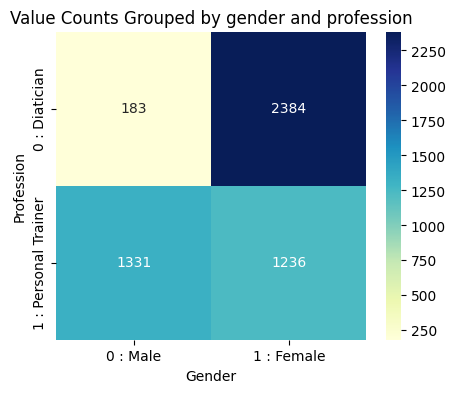

In [ ]:
# Oversample minority class
minority_class_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

balanced_data = pd.concat([majority_class, minority_class_oversampled])

balanced_dataset = Dataset.from_pandas(balanced_data, split='train')

labels_pandas = pd.DataFrame(balanced_data['profession'])
class_counts = labels_pandas.value_counts().sort_values(ascending=False)
print(class_counts)

filtered_bias_in_bios['train'] = balanced_dataset

labels = ['0 : Diatician', '1 : Personal Trainer']
gen = ['0 : Male', '1 : Female']
data = pd.crosstab(balanced_data['profession'], balanced_data['gender'])
plt.figure(figsize=(5,4))
sns.heatmap(data, annot=True, fmt = '.0f', cmap="YlGnBu" , yticklabels=labels, xticklabels=gen, annot_kws={"size":10})
plt.xlabel('Gender')
plt.ylabel('Profession')
plt.title('Value Counts Grouped by gender and profession')

plt.show()

In [ ]:
from datasets import Dataset
from datasets import load_dataset

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

#Tokenizing function to get the right columns
def tokenize_function(examples):
    tokens = tokenizer(examples['hard_text'], truncation=True)
    tokens['gender'] = examples['gender']
    return tokens

tokenized_datasets = filtered_bias_in_bios.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['hard_text'])
tokenized_datasets = tokenized_datasets.rename_column('profession', 'labels')
tokenized_datasets = tokenized_datasets.map(lambda x: {"gender": x["gender"]}, batched=True)
tokenized_datasets = tokenized_datasets.with_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'gender'])

print(f"Columns in the tokenized datasets: {tokenized_datasets['train'].column_names}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5134 [00:00<?, ? examples/s]

Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Map:   0%|          | 0/5134 [00:00<?, ? examples/s]

Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

Map:   0%|          | 0/540 [00:00<?, ? examples/s]

Columns in the tokenized datasets: ['labels', 'gender', '__index_level_0__', 'input_ids', 'attention_mask']


In [ ]:
import torch
from torch.utils.data import DataLoader

# Custom Data Collator is needed to include the gender column
class CustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        input_ids = [f["input_ids"] for f in features]
        attention_mask = [f["attention_mask"] for f in features]
        genders = [f["gender"] for f in features]
        labels = [f["labels"] for f in features]

        padded_inputs = self.tokenizer.pad(
            {"input_ids": input_ids, "attention_mask": attention_mask},
            padding=True,
            return_tensors="pt"
        )

        batch = {
            "input_ids": padded_inputs["input_ids"],
            "attention_mask": padded_inputs["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
            "gender": torch.tensor(genders, dtype=torch.long),
        }

        return batch

In [ ]:
print(tokenizer)

collator = CustomDataCollator(tokenizer)
train_dataloader = DataLoader(
    tokenized_datasets['train'], shuffle=True, batch_size=20, collate_fn=collator
)
eval_dataloader = DataLoader(
    tokenized_datasets['dev'], batch_size=20, collate_fn=collator
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=20, collate_fn=collator, drop_last=False
)

batch = train_dataloader.__iter__().__next__()
print(batch.keys())

batch_sizes = [len(batch["labels"]) for batch in test_dataloader]
print(f"Batch sizes: {batch_sizes}")
print(f"Total processed samples: {sum(batch_sizes)}")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
dict_keys(['input_ids', 'attention_mask', 'labels', 'gender'])
Batch sizes: [20, 20, 20, 20, 20, 20, 20, 20, 20, 2

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def fairness_loss(predictions, true_labels, group_labels, profession_labels,
                  base_loss_fn, lambda_tpr=1.0, lambda_fpr=1.0, device='cuda:0'):
    # Base classification loss, cross entropy
    loss = base_loss_fn(predictions, true_labels)
    unique_professions = torch.unique(profession_labels)
    unique_groups = torch.unique(group_labels)

    tpr_diff, fpr_diff = 0.0, 0.0
    # nested for loop to go through each gender for each profession
    for profession in unique_professions:
        profession_tprs, profession_fprs, group_sizes = [], [], []
        for group in unique_groups:
            mask = (profession_labels == profession) & (group_labels == group)

            if mask.sum() > 0:
                group_preds = torch.argmax(predictions[mask], dim=1)
                group_true = true_labels[mask]

                # Collecting TP, FN, TN, FP for each
                tp = ((group_preds == 1) & (group_true == 1)).sum().float()
                fn = ((group_preds == 0) & (group_true == 1)).sum().float()
                tn = ((group_preds == 0) & (group_true == 0)).sum().float()
                fp = ((group_preds == 1) & (group_true == 0)).sum().float()

                tp, fn, tn, fp = tp.to(device), fn.to(device), tn.to(device), fp.to(device)

                tpr = tp / (tp + fn + 1e-6)
                fpr = fp / (fp + tn + 1e-6)

                profession_tprs.append(tpr)
                profession_fprs.append(fpr)
                group_sizes.append(mask.sum().item())

        # get mean TPR/FPR weighted by group sizes
        group_sizes = torch.tensor(group_sizes, dtype=torch.float32).to(device)
        if group_sizes.sum() > 0:
            mean_tpr = (torch.stack(profession_tprs) * group_sizes).sum() / group_sizes.sum()
            mean_fpr = (torch.stack(profession_fprs) * group_sizes).sum() / group_sizes.sum()
        else:
            mean_tpr, mean_fpr = torch.tensor(0.0, device=device), torch.tensor(0.0, device=device)

        # get the distance of the TPR in respect to the average TPR of both groups
        tpr_diff += sum(torch.abs(tpr - mean_tpr) for tpr in profession_tprs)
        fpr_diff += sum(torch.abs(fpr - mean_fpr) for fpr in profession_fprs)

    fairness_penalty = (lambda_tpr * tpr_diff + lambda_fpr * fpr_diff)
    total_loss = loss + fairness_penalty
    # Return total loss with fairness penalty
    return total_loss

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm

num_epochs = 20
batch_size = 20

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Training loop
for epoch in range(num_epochs):
    total_loss = 0
    model.train()

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        gender = batch["gender"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = fairness_loss(
            predictions=logits,
            true_labels=labels,
            group_labels=gender,
            profession_labels=labels,
            base_loss_fn=torch.nn.CrossEntropyLoss(),
            lambda_tpr=0.9,
            lambda_fpr=0.7,
            device=device
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

    total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_dataloader)}")

print("Training complete!")

Training Epoch 1/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 1 - Loss: 2.389200256434396e-07


Training Epoch 2/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 2 - Loss: 2.094864272711806e-06


Training Epoch 3/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 3 - Loss: 2.717811521188019e-08


Training Epoch 4/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 4 - Loss: 1.9696967453530044e-08


Training Epoch 5/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 5 - Loss: 1.4322975594147221e-08


Training Epoch 6/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 6 - Loss: 1.0502829775791742e-08


Training Epoch 7/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 7 - Loss: 6.576715438565102e-09


Training Epoch 8/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 8 - Loss: 1.1274791715040636e-08


Training Epoch 9/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 9 - Loss: 8.862817074273666e-09


Training Epoch 10/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 10 - Loss: 6.73243499859594e-09


Training Epoch 11/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 11 - Loss: 3.853259653419008e-09


Training Epoch 12/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 12 - Loss: 2.7565899688264912e-09


Training Epoch 13/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 13 - Loss: 6.328222110618589e-09


Training Epoch 14/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 14 - Loss: 4.482767561390355e-09


Training Epoch 15/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 15 - Loss: 4.800837676383733e-09


Training Epoch 16/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 16 - Loss: 7.540855908577044e-09


Training Epoch 17/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 17 - Loss: 8.246566290192121e-09


Training Epoch 18/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 18 - Loss: 7.928480250194237e-09


Training Epoch 19/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 19 - Loss: 7.693256432252143e-09


Training Epoch 20/20:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 20 - Loss: 6.046598137881569e-09
Training complete!


In [ ]:
model.eval()
all_preds = []
all_true_labels = []
all_genders = []

#Evaluate with test set
with torch.no_grad():
    for batch in test_dataloader:  # Use test_dataloader here
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        genders = batch["gender"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        all_genders.extend(genders.cpu().numpy())

In [ ]:
#Create a dataframe with results
results_df = pd.DataFrame({
    "true_labels": all_true_labels,
    "preds": all_preds,
    "gender": all_genders
})
print(f"Total samples in test set: {len(tokenized_datasets['test'])}")
print(f"Total samples in results_df: {results_df.shape[0]}")

Total samples in test set: 1347
Total samples in results_df: 1347


In [ ]:
def calculate_metrics(results_df, profession_code, gender_code):
    subset = results_df[results_df["gender"] == gender_code]
    print(f"Subset size for profession={profession_code}, gender={gender_code}: {subset.shape}")

    true_binary = (subset["true_labels"] == profession_code).astype(int)
    pred_binary = (subset["preds"] == profession_code).astype(int)

    # generate confusion matrix
    TN, FP, FN, TP = confusion_matrix(true_binary, pred_binary).ravel()
    print(f"Confusion Matrix for Profession {profession_code} and Gender {gender_code}:")
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

    # generate final TPR and FPR
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    return tpr, fpr

In [ ]:
professions = {0: 'Dietician', 1: 'Personal Trainer'}
genders = {0: 'male', 1: 'female'}

tpr_results = {}
fpr_results = {}
for profession_code, profession_name in professions.items():
    for gender_code, gender_name in genders.items():
        # Printing out TPR and FPR results
        tpr, fpr = calculate_metrics(results_df, profession_code, gender_code)
        tpr_results[(profession_name, gender_name)] = tpr
        print(f"TPR for {profession_name} ({gender_name}): {tpr:.4f}")
        fpr_results[(profession_name, gender_name)] = fpr
        print(f"FPR for {profession_name} ({gender_name}): {fpr:.4f}")

Subset size for profession=0, gender=0: (266, 3)
Confusion Matrix for Profession 0 and Gender 0:
TP: 68, FP: 18, TN: 177, FN: 3
TPR for Dietician (male): 0.9577
FPR for Dietician (male): 0.0923
Subset size for profession=0, gender=1: (1081, 3)
Confusion Matrix for Profession 0 and Gender 1:
TP: 905, FP: 19, TN: 144, FN: 13
TPR for Dietician (female): 0.9858
FPR for Dietician (female): 0.1166
Subset size for profession=1, gender=0: (266, 3)
Confusion Matrix for Profession 1 and Gender 0:
TP: 177, FP: 3, TN: 68, FN: 18
TPR for Personal Trainer (male): 0.9077
FPR for Personal Trainer (male): 0.0423
Subset size for profession=1, gender=1: (1081, 3)
Confusion Matrix for Profession 1 and Gender 1:
TP: 144, FP: 13, TN: 905, FN: 19
TPR for Personal Trainer (female): 0.8834
FPR for Personal Trainer (female): 0.0142
